# Big Iron

See <a href="https://www.kaggle.com/competitions/bluebook-for-bulldozers/leaderboard">Blue Book for Bulldozers</a> leaderboard page.

BTW this notebook borrows heavily from <a href="https://github.com/fastai/fastbook/blob/master/09_tabular.ipynb">chapter 9</a> of
<a href="https://github.com/fastai/fastbook">Fastai's FastBook.
    
<mark>Fastai also has a set of <a href="https://www.fast.ai/posts/2022-07-21-dl-coders-22.html">online courses</a> and librarys (see below) designed to show regular people how to apply advanced machine and deep learning algorithms to real world problems.  Its extremely applied and fortunately, much of the complexity is handled by the library itself.  
    
<b>It is the best course I know of for teaching AI, Machine Learning and Data Science.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
# Set max rows and columns displayed in jupyter
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

#the following gives access to utils folder
#where utils package stores shared code
import os
import sys
PROJECT_ROOT = os.path.abspath(os.path.join(
                  os.getcwd(),
                  os.pardir)
)

#only add it once
if (PROJECT_ROOT not in sys.path):
    sys.path.append(PROJECT_ROOT)
    
import utils as ut

#want to use a subset of the data?
use_latest=False
latest_size=200000

<mark>install fastai

In [2]:
#install fastai library
# !pip install fastai
#or see https://pypi.org/project/fastai/

# Get the data

In [3]:
#install kaggle api
# !pip install kaggle

In [4]:
#if you have the Kaggle api installed then use it
# !kaggle competitions download -c bluebook-for-bulldozers

In [5]:
#uhoh...my key is exposed, get your key from kaggle place it in the noted folder
# !chmod 600 /home/keith/.kaggle/kaggle.json

# EDA

In [6]:
df=pd.read_csv('./data/TrainAndValid.csv')
print(df.shape)

(412698, 53)


/tmp/ipykernel_1007057/1701633161.py:1: DtypeWarning: Columns (13,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('./data/TrainAndValid.csv')


### Note the sale date, this is a time series problem, that changes how we split the data into train and validation set (cannot use random splitter)

To split: Older data is training data, Newer data is validation data.  This keeps information from leaking from the validation set back to the training set.

### Lets see what the date range is

In [7]:
df['saledate']=pd.to_datetime(df['saledate'])

In [8]:
print(f'earliest date= {df.saledate.min()}, latest date={df.saledate.max()}')

earliest date= 1989-01-17 00:00:00, latest date=2012-04-28 00:00:00


### Sort the dataframe by saledate in preparation for splitting into train and validation sets
<mark> train on oldest, test on newest

In [9]:
df.sort_values(by=['saledate'], inplace=True)

if(use_latest):
    df=df[-latest_size:]
len(df)

412698

### Add a Time field for the Linear regressor that we will use to subtract the trend

In [10]:
dates=pd.DatetimeIndex(df.saledate)
df['Time']=[(dates[i]-dates[0]).days for i in range(len(df))]

# df[['saledate','Time']].head(20)

## <mark>Hmmm.. this dataset has sales around 2007, when the almost great depression hit

I wonder if a vix entry would help?  Goto <a href="https://www.macrotrends.net/2603/vix-volatility-index-historical-chart">VIX Volatility Index - Historical Chart</a> to grab this data, get all years and download the csv.  See if it helps, if so keep it, if not dont.

In [11]:
dfvix=pd.read_csv('./vix-volatility-index-historical-chart.csv',skiprows=15)
dfvix['date'] =  pd.to_datetime(dfvix['date'])
dfvix.head()
# dfvix['date'].head()

,date,value
0,1990-01-02,17.24
1,1990-01-03,18.19
2,1990-01-04,19.22
3,1990-01-05,20.11
4,1990-01-08,20.26


### merge 2 datasets

In [12]:
#turns out it hurts, oh well...
# df = pd.merge(df,dfvix, left_on='saledate', right_on='date', how='left')

# df.drop(columns=['date'],inplace=True)
# df[' value'].fillna(method='backfill',inplace=True)
# df[' value'].fillna(method='ffill',inplace=True)

### <mark>Split Dates into more useful features

Its hard for a random forest to use a datetime object since it has a lot of encoded information (the year,the month, the day of the week, weekday, weekend, holiday, end of quarter etc.).  We can slog through and manually create these features, or use fastai, a library that already does this.

In [13]:
#using a fastai helper function to get ALL the date info
from fastai.tabular import core
df = core.add_datepart(df, 'saledate')

#look at all those additional sale columns
# [col for col in df.columns if 'sale' in col]

Any obvious outliers?

In [14]:
df.describe()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,Time,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed
count,4.126980e+05,412698.000000,4.126980e+05,412698.000000,412698.000000,392562.000000,412698.000000,1.475040e+05,412698.000000,412698.000000,412698.000000,412698.000000,412698.000000,412698.000000,412698.000000,4.126980e+05
mean,2.011161e+06,31215.181414,1.230061e+06,6947.201828,135.169361,6.585268,1899.049637,3.522988e+03,5754.079366,2004.317382,6.300268,25.721191,16.152894,2.594338,176.784094,1.098151e+09
std,1.080068e+06,23141.743695,4.539533e+05,6280.824982,9.646749,17.158409,292.190243,2.716993e+04,2123.225527,5.821090,3.437276,14.841265,8.429510,1.417971,103.910718,1.834467e+08
min,1.139246e+06,4750.000000,0.000000e+00,28.000000,121.000000,0.000000,1000.000000,0.000000e+00,0.000000,1989.000000,1.000000,1.000000,1.000000,0.000000,1.000000,6.009984e+08
25%,1.421898e+06,14500.000000,1.088593e+06,3261.000000,132.000000,1.000000,1985.000000,0.000000e+00,4341.000000,2000.000000,3.000000,12.000000,9.000000,2.000000,82.000000,9.760608e+08
50%,1.645852e+06,24000.000000,1.284397e+06,4605.000000,132.000000,2.000000,1995.000000,0.000000e+00,6371.000000,2006.000000,6.000000,24.000000,16.000000,3.000000,165.000000,1.151453e+09
75%,2.261012e+06,40000.000000,1.478079e+06,8899.000000,136.000000,4.000000,2001.000000,3.209000e+03,7436.000000,2009.000000,9.000000,39.000000,23.000000,3.000000,270.000000,1.243469e+09
max,6.333349e+06,142000.000000,2.486330e+06,37198.000000,173.000000,99.000000,2014.000000,2.483300e+06,8502.000000,2012.000000,12.000000,53.000000,31.000000,6.000000,365.000000,1.335571e+09


### <mark>YearMade has some tractors made in the year 1000, how to fix this?

<AxesSubplot:xlabel='YearMade', ylabel='Count'>

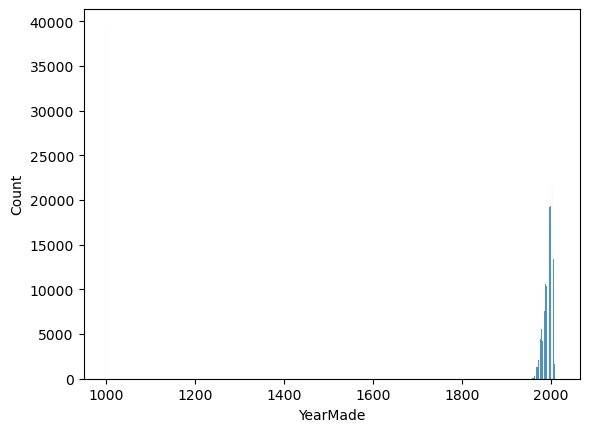

In [15]:
sns.histplot(df,x='YearMade')

In [16]:
#how many made before 1950?
n=df.loc[df.YearMade<1950]
n.shape[0]

39542

### Maybe we can use groupby to infer the incorrect YearMades?

In [17]:
#look for good columns to groupby, dont use ones with a lot of NaNs

# df.nunique().sort_values()
# df.select_dtypes(include=['object'])
# df.select_dtypes(include=['object']).dtypes

#find good columns to groupby
tmp=df.loc[:,['fiModelDesc','ModelID','fiBaseModel','fiModelSeries','fiModelDescriptor','fiProductClassDesc']]

#want few nulls
tmp.isnull().sum()

fiModelDesc                0
ModelID                    0
fiBaseModel                0
fiModelSeries         354031
fiModelDescriptor     337882
fiProductClassDesc         0
dtype: int64

In [18]:
#ok no 'fiModelSeries','fiModelDescriptor'
tmp=tmp.drop(columns=['fiModelSeries','fiModelDescriptor'])

In [19]:
def impute_YearMade(df,year=1950):
    '''
    replace any YearMade<year with the max for the below groupby or year

    df: dataframe to impute YearMade on
    year: anything below this year is imputed, if cannot be imputed set to year
    '''
    #lets try fiBaseModel and fiProductClassDesc for mean YearBuilt
    estimates=df.groupby(['fiModelDesc','fiProductClassDesc']).YearMade.max()
    
    #for a given row, look up and return the mean YearMade
    def impute_yb(x):
        est=estimates[(x['fiModelDesc'],  x['fiProductClassDesc'])]
        if est is np.nan or est < year:
            est=year
        return est
  
    df['YearMade']=df.apply(lambda x:impute_yb(x) if x.YearMade<year else x.YearMade,axis=1)   
    return df

In [20]:
df=impute_YearMade(df)

### See what the most sales dates are

<AxesSubplot:>

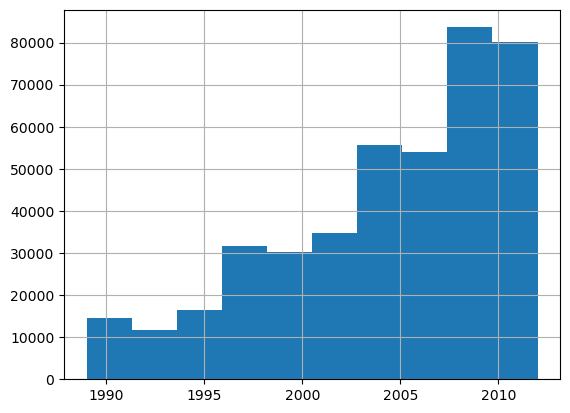

In [21]:
df.saleYear.hist()

### Maybe the older data is not as relevant?  Drop everything <2003

Also not as much of it

In [22]:
filt=df['saleYear']>2004
df=df[filt]

## Prepare the rest of the data (the super easy way)

Use FastAI's TabularPandas class to prepare data

### Dependant var

We are trying to predict 'SalePrice'.  Specifically the root mean squared log error (RMSLE) between the actual and predicted values.  Start by taking the log of the dependant variable (the L of RMSLE) 

In [23]:
dep_var = 'SalePrice'
#take the log of dependant var since that is what the contest wants
df[dep_var] = np.log(df[dep_var])

### Get the indexes of train and test

Its a time series, the latest entries are the test set, the earlier ones, the train set.  Everything later than Oct 2010 is test

In [24]:
cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

### Obvious ordinal Categorical

In [25]:
df['ProductSize'].unique()

array(['Large / Medium', 'Medium', 'Small', nan, 'Mini', 'Large',
       'Compact'], dtype=object)

In [26]:
szs=[ 'Large','Large / Medium','Medium','Compact','Small','Mini']
szs_to_i={i:v for v,i in enumerate(szs)}
df['ProductSize'] = df['ProductSize'].map(szs_to_i)

### <mark>What are the other categorical and the continuous variables?

Easy to ID: cat columns are objects or ints with small cardinality, continuous are ints with large cardinality or floats.  

We can get this easily using dtypes and nunique, or we can use a fastai function that does it for us in 1 go.

In [27]:
# using these? 
# df.dtypes
# df.SalesID.nunique()

In [28]:
from fastai.tabular.all import *
cont,cat = cont_cat_split(df,max_card=1, dep_var=dep_var)

### Some transforms for the data

In [29]:
from fastai.tabular.all import *

#Categorify transform- replaces a column with a numeric categorical column
#FillMissing - replaces missing values with median for the column and creates 
#a new Boolean column that is set to True for any row where the value was missing. 
procs = [Categorify, FillMissing]

## Now lets create a TabularDataFrame that will autotransform columns for our model

Its mostly a wrapper around a DataFrame that does some work for us

In [30]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [31]:
len(to.train),len(to.valid)

(230144, 7988)

In [32]:
#strings still displayed
to.show(5)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,ProductSize_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,ProductSize,Time,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
10704,Medium,EC280LC,EC280,#na#,#na#,LC,"Hydraulic Excavator, Track - 28.0 to 33.0 Metric Tons",Connecticut,TEX,Track Excavators,#na#,EROPS,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,#na#,#na#,#na#,#na#,#na#,Manual,#na#,#na#,#na#,Steel,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,False,1174825,1056544,22911,121,3.0,1998,4401.0,1.0,5837,2005,1,2,10,0,10,1.105315e+09,11.018629
10644,Low,980B,980,B,#na#,#na#,Wheel Loader - 275.0 to 350.0 Horsepower,California,WL,Wheel Loader,#na#,OROPS,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,False,1174686,1038563,3876,121,3.0,1970,3067.0,2.0,5838,2005,1,2,11,1,11,1.105402e+09,9.132379
10646,Medium,315L,315,#na#,#na#,L,"Hydraulic Excavator, Track - 14.0 to 16.0 Metric Tons",New Jersey,TEX,Track Excavators,#na#,EROPS,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,#na#,#na#,#na#,#na#,#na#,None or Unspecified,#na#,#na#,#na#,Steel,24 inch,None or Unspecified,None or Unspecified,None or Unspecified,Double,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,False,1174694,1018458,1133,121,3.0,1995,7835.0,4.0,5840,2005,1,2,13,3,13,1.105574e+09,10.545341
10727,Medium,416C,416,C,#na#,#na#,Backhoe Loader - 14.0 to 15.0 Ft Standard Digging Depth,North Carolina,BL,Backhoe Loaders,Two Wheel Drive,OROPS,Yes,None or Unspecified,No,Standard,Standard,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,True,1174885,112264,3538,121,3.0,2000,2312.0,2.0,5840,2005,1,2,13,3,13,1.105574e+09,10.126631
90708,#na#,226,226,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,Unspecified,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,True,True,1399078,1398984,7009,132,3.0,2002,0.0,2.0,5840,2005,1,2,13,3,13,1.105574e+09,9.510445


In [33]:
#grab the DataFrame though and you see that its been transformed
to.items.head()
type(to.items)

pandas.core.frame.DataFrame

### Lets get our train and test sets

In [34]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [35]:
#dataset for the linear regressor part of the BoostedHybrid model
xs_linreg=xs.loc[:,['Time']]
valid_xs_linreg=valid_xs.loc[:,['Time']]

### Train model

The same one we have been using for other time series analysis, no lags though, they are not appropriate for this problem

In [37]:
from sklearn import linear_model
from catboost import CatBoostRegressor

#if you have optuna trial parameters from below then plug in here (**trial.params,silent=True, random_state=42)
hm=ut.BoostedHybrid(model_1 = linear_model.LinearRegression(), model_2=CatBoostRegressor(silent=True, random_state=42), num_lags=0)

In [38]:
#fit it
hm.fit(xs_linreg,xs,y)

## Get test set predictions and competition metric error, rmse

In [39]:
#get our target value, the training set for linear regression, and the training set for catboost
#get predictions on test set
preds=hm.predict(valid_xs_linreg,valid_xs,valid_y,False)

Create a function to check the root mean squared error of our model (`m_rmse`), since that's how the competition was judged:

In [40]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)

In [41]:
r_mse(preds, valid_y)

0.237888

## Not bad, and this is before we do any other data augmentaton or hyperparameter tuning using Optuna

<mark>Also this score would place at 15th out of 474 teams IFF our validation set is like the test set that only Kaggle has.


### Maybe we can fine tune the catboost regressor?

In [42]:
#see what we have now, helps set ranges for optuna
hm.model_2.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'random_seed': 42,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learning_rate': 0.09668900072574615,
 'score_function': 'Cosine',
 'task_type

In [43]:
%%time
from sklearn.metrics import mean_squared_error
import optuna
import sklearn
def objective(trial):
    #these are the parameters I want to optimize
    params = {
        'learning_rate':trial.suggest_discrete_uniform("learning_rate", 0.001, 0.11, 0.001),
        'depth': trial.suggest_int("depth", 1, 12),
        'l2_leaf_reg':trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.5, 0.5),
        'iterations':1000,
        'silent':True,
        'random_state':42
    }
 
    # Define the model. Pass in params to be tuned
    clf=ut.BoostedHybrid(model_1 = linear_model.LinearRegression(), model_2=CatBoostRegressor(**params), num_lags=0)
    
    #fit it
    clf.fit(xs_linreg,xs,y)
    
    #get preds
    preds=clf.predict(valid_xs_linreg,valid_xs,valid_y,False)

    return r_mse(preds,valid_y)
 
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

trial = study.best_trial

print('root_mean_squared_error: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2023-04-19 02:55:08,485] A new study created in memory with name: no-name-37b83071-65f7-4af1-9027-f44217fca585
[I 2023-04-19 02:55:41,279] Trial 0 finished with value: 0.231601 and parameters: {'learning_rate': 0.048, 'depth': 10, 'l2_leaf_reg': 3.0}. Best is trial 0 with value: 0.231601.
[I 2023-04-19 02:55:46,848] Trial 1 finished with value: 0.308943 and parameters: {'learning_rate': 0.065, 'depth': 2, 'l2_leaf_reg': 5.5}. Best is trial 0 with value: 0.231601.
[I 2023-04-19 02:56:34,484] Trial 2 finished with value: 0.229267 and parameters: {'learning_rate': 0.065, 'depth': 11, 'l2_leaf_reg': 5.0}. Best is trial 2 with value: 0.229267.
[I 2023-04-19 02:56:41,036] Trial 3 finished with value: 0.27388 and parameters: {'learning_rate': 0.093, 'depth': 3, 'l2_leaf_reg': 4.5}. Best is trial 2 with value: 0.229267.
[I 2023-04-19 02:56:48,555] Trial 4 finished with value: 0.276831 and parameters: {'learning_rate': 0.045, 'depth': 4, 'l2_leaf_reg': 5.0}. Best is trial 2 with value: 0.229

root_mean_squared_error: 0.229267
Best hyperparameters: {'learning_rate': 0.065, 'depth': 11, 'l2_leaf_reg': 5.0}
CPU times: user 21min 19s, sys: 12.5 s, total: 21min 31s
Wall time: 1min 40s


In [44]:
#plug these into model above and try again
trial.params

{'learning_rate': 0.065, 'depth': 11, 'l2_leaf_reg': 5.0}

In [45]:
#not satisfied?  Keep on optimizing from where you left off above
study.optimize(objective, n_trials=10)

[I 2023-04-19 02:56:57,113] Trial 5 finished with value: 0.298217 and parameters: {'learning_rate': 0.014000000000000002, 'depth': 5, 'l2_leaf_reg': 4.5}. Best is trial 2 with value: 0.229267.
[I 2023-04-19 02:57:05,581] Trial 6 finished with value: 0.245267 and parameters: {'learning_rate': 0.10200000000000001, 'depth': 5, 'l2_leaf_reg': 2.5}. Best is trial 2 with value: 0.229267.
[I 2023-04-19 02:57:10,336] Trial 7 finished with value: 0.345531 and parameters: {'learning_rate': 0.060000000000000005, 'depth': 1, 'l2_leaf_reg': 4.0}. Best is trial 2 with value: 0.229267.
[I 2023-04-19 02:57:15,128] Trial 8 finished with value: 0.346538 and parameters: {'learning_rate': 0.058, 'depth': 1, 'l2_leaf_reg': 2.5}. Best is trial 2 with value: 0.229267.
[I 2023-04-19 02:57:21,806] Trial 9 finished with value: 0.298435 and parameters: {'learning_rate': 0.039, 'depth': 3, 'l2_leaf_reg': 2.0}. Best is trial 2 with value: 0.229267.
[I 2023-04-19 02:58:38,747] Trial 10 finished with value: 0.228187

## The best score from above Optuna run is .228187

<mark>This would have won the Kaggle competition IFF our validation set is like the test set that only Kaggle has.